# House Price (SA1) Data Analysis

## Objective of notebook
- To produce supportig evidence to analyse housing data and it's relationships in NZ Satstical Area 1

## Method
- Build data via importing, API call and merging (adding 2018 Census population and Deprivation Index)
- Clean data for analysis and building a Machine Learning Module


## 1.Data building with merging and API calls

### Import all required libraries

In [47]:
import json ## for parsing strings and files
import sys
sys.path.append('home/nbuser/library/')

import re ## for searching regular expressions through data
import math ## for math functions
import pandas as pd  ## for data fram usage
import requests ## API call
import matplotlib.pyplot as plt ## for visualisations
import seaborn as sns; sns.set() ## for nicer visualisations
import numpy as np
from sklearn.linear_model import LinearRegression ##Linear Regression models
from sklearn.model_selection import train_test_split ## Machine Learning models
from sklearn.ensemble import RandomForestClassifier ## Machine Learning model for accuracy boosting (limit overfitting)
from sklearn.metrics import roc_auc_score ## use to grade accuracy of model
from sklearn.metrics import confusion_matrix ## use to visualise true/fast positives/negatives

### Importing provided file

In [2]:
df1 = pd.read_csv('Dataset-for-Assignment.csv')
df1.head()

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park


## Creating API call function

In [8]:
def get_cPop(Combined_Coordinates):
## Variable to fill params

    url = 'https://koordinates.com/services/query/v1/vector.json'

    
    
## All required parameters for koordinates
    params = { 
        'key': 'b7e995c7c99a4efaaba809b86d681ce9', ## API Key from koordinates.com
        'layer': '104612', ## Layer ID from Stats.gov.nz (2018 Census Total NZ, Statistical Area 1)
        'x': Combined_Coordinates[0], 
        'y': Combined_Coordinates[1],
    }
    
   
    ## Functinon to check for errors. Returns status code for troubleshooting if error occurs    
    response = requests.get(url, params=params)

    if response.status_code !=200:
        return pd.Series({ '2018_Census_Population' : response.status_code})

    ## Returned as panda Series for dataframe to use.
    
    ## Function to return cPop, Must be transformed into panda Series
    cPop = response.json()['vectorQuery']['layers']['104612']['features'][0]['properties']['C18_CURPop']
    return pd.Series({'2018_Census_Population' : cPop})

In [4]:
## Test Function
## get_cPop('174.904069','-37.012920')

In [9]:
## Checking data type
type(df1.Latitude)

pandas.core.series.Series

### Creating small sample data to test function and save time on API calls

In [10]:
## Sample contains first 5 rows of origional data
sample = df1.head(5)

In [11]:
sample

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park


### Creating function that takes 2 values for API call

In [12]:
def combine_lat_lng(Longitude,Latitude):
     return (Longitude,Latitude)
   ## return pd.Series({'Combined_Coordinates' : [Longitude,Latitude]})

In [13]:
## using lambda function to combine multiple values. axis = 1 to read 'row'wise
sample['Combined_Coordinates'] = sample.apply(lambda x: combine_lat_lng(x['Longitude'], x['Latitude']), axis=1)
## one set of [] was used as only one column is created.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [14]:
sample

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,Combined_Coordinates
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,"(174.90406940000003, -37.0129205)"
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,"(174.9229121, -37.0636724)"
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,"(174.9240444, -37.063579700000005)"
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,"(174.78742490000002, -36.9129964)"
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,"(174.8926119, -36.979036900000004)"


In [11]:
sample.Combined_Coordinates

0     (174.90406940000003, -37.0129205)
1            (174.9229121, -37.0636724)
2    (174.9240444, -37.063579700000005)
3     (174.78742490000002, -36.9129964)
4    (174.8926119, -36.979036900000004)
Name: Combined_Coordinates, dtype: object

### Utilizing new combined column to apply API call function

In [15]:
sample['2018_Census_Population'] = sample.Combined_Coordinates.apply(get_cPop)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [16]:
sample

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,Combined_Coordinates,2018_Census_Population
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,"(174.90406940000003, -37.0129205)",174
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,"(174.9229121, -37.0636724)",129
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,"(174.9240444, -37.063579700000005)",129
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,"(174.78742490000002, -36.9129964)",120
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,"(174.8926119, -36.979036900000004)",231


## Confirmed API call success. Applying to primary data.

In [17]:
df1['Combined_Coordinates'] = df1.apply(lambda x: combine_lat_lng(x['Longitude'], x['Latitude']), axis=1)
df1['2018_Census_Population'] = df1.Combined_Coordinates.apply(get_cPop)

In [18]:
df1

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,Combined_Coordinates,2018_Census_Population
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,"(174.90406940000003, -37.0129205)",174
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,"(174.9229121, -37.0636724)",129
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,"(174.9240444, -37.063579700000005)",129
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,"(174.78742490000002, -36.9129964)",120
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,"(174.8926119, -36.979036900000004)",231
5,3,1.0,"14 Tainui Terrace Mangere Bridge, Auckland",100,1050000,-36.943929,174.780501,7007917,63,15,24,33,30,39,Mangere Bridge,"(174.78050149999999, -36.943928899999996)",195
6,3,1.0,"54 Kelmarna Avenue Ponsonby, Auckland",531,2525000,-36.849239,174.734451,7004908,33,12,18,12,15,9,Ponsonby,"(174.73445130000002, -36.849238899999996)",102
7,3,2.0,"39 Rawhiti Road One Tree Hill, Auckland",1024,1400000,-36.907700,174.796042,7005903,36,33,39,21,12,24,One Tree Hill,"(174.7960425, -36.9077)",162
8,3,2.0,"17b Tawa Crescent Manurewa, Auckland",80,475000,-37.033322,174.898113,7009808,45,27,15,12,12,12,Manurewa,"(174.89811310000002, -37.033322399999996)",126
9,4,2.0,"39a Keegan Drive Massey, Auckland",204,660000,-36.846208,174.620794,7003826,30,27,36,15,24,12,Massey,"(174.62079440000002, -36.8462083)",141


In [20]:
## Save dataset for future use to lower time consuption of API call.
df1.to_csv('Completed_dataset.csv', index=False)

##### To save load times Completed_dataset.csv will be loaded into df1 from this point onwards.

In [3]:
df1 = pd.read_csv('Completed_dataset.csv')
df1.head()

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,Combined_Coordinates,2018_Census_Population
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,"(174.90406940000003, -37.0129205)",174
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,"(174.9229121, -37.0636724)",129
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,"(174.9240444, -37.063579700000005)",129
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,"(174.78742490000002, -36.9129964)",120
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,"(174.8926119, -36.979036900000004)",231


### Import Depravation Index Data for merging

In [4]:
df2 = pd.read_excel('2018_Otago_Deprivation_Index.xlsx')
df2.head()

,SA12018_code,NZDep2018,NZDep2018_Score,URPopnSA1_2018,SA22018_code,SA22018_name
0,7000000,10.0,1245.0,141,100100,North Cape
1,7000001,10.0,1245.0,114,100100,North Cape
2,7000002,NaN,NaN,0,100300,Inlets Far North District
3,7000003,10.0,1207.0,225,100100,North Cape
4,7000004,9.0,1093.0,138,100100,North Cape


### Merging House Data (df1) with Deprivation Index Data (df2)

In [5]:
df_Main = pd.merge(df1, df2, left_on='SA1', right_on='SA12018_code')

In [6]:
df_Main

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,...,60+ years,Suburbs,Combined_Coordinates,2018_Census_Population,SA12018_code,NZDep2018,NZDep2018_Score,URPopnSA1_2018,SA22018_code,SA22018_name
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,...,21,Manurewa,"(174.90406940000003, -37.0129205)",174,7009770,6.0,997.0,174,159600,Hillpark North
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,...,30,Karaka,"(174.9229121, -37.0636724)",129,7009991,1.0,881.0,129,162500,Hingaia
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,...,30,Karaka,"(174.9240444, -37.063579700000005)",129,7009991,1.0,881.0,129,162500,Hingaia
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,...,15,Onehunga,"(174.78742490000002, -36.9129964)",120,7007871,2.0,908.0,120,144300,Onehunga North
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,...,33,Clover Park,"(174.8926119, -36.979036900000004)",231,7008902,9.0,1091.0,231,157700,Clover Park North
5,3,1.0,"14 Tainui Terrace Mangere Bridge, Auckland",100,1050000,-36.943929,174.780502,7007917,63,15,...,39,Mangere Bridge,"(174.78050149999999, -36.943928899999996)",195,7007917,4.0,942.0,195,146800,Mangere Bridge
6,3,1.0,"54 Kelmarna Avenue Ponsonby, Auckland",531,2525000,-36.849239,174.734451,7004908,33,12,...,9,Ponsonby,"(174.73445130000002, -36.849238899999996)",102,7004908,4.0,951.0,102,130400,Ponsonby West
7,3,2.0,"39 Rawhiti Road One Tree Hill, Auckland",1024,1400000,-36.907700,174.796042,7005903,36,33,...,24,One Tree Hill,"(174.7960425, -36.9077)",162,7005903,4.0,951.0,162,142800,One Tree Hill
8,3,2.0,"17b Tawa Crescent Manurewa, Auckland",80,475000,-37.033322,174.898113,7009808,45,27,...,12,Manurewa,"(174.89811310000002, -37.033322399999996)",126,7009808,10.0,1164.0,126,160900,Manurewa South
9,4,2.0,"39a Keegan Drive Massey, Auckland",204,660000,-36.846208,174.620794,7003826,30,27,...,12,Massey,"(174.62079440000002, -36.8462083)",141,7003826,6.0,988.0,141,122500,Massey East


# Cleaning data
- Dropping columns that wont be used
- Renaming columns for easier analysis and prevent potential issues
- Setting up correct data types

### Dropping all unnessary columns

In [9]:
df_HouseData = df_Main.drop(columns=['Combined_Coordinates','SA12018_code','NZDep2018_Score','URPopnSA1_2018','SA22018_code','SA22018_name'])
df_HouseData

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,2018_Census_Population,NZDep2018
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,174,6.0
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,129,1.0
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,129,1.0
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,120,2.0
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,231,9.0
5,3,1.0,"14 Tainui Terrace Mangere Bridge, Auckland",100,1050000,-36.943929,174.780502,7007917,63,15,24,33,30,39,Mangere Bridge,195,4.0
6,3,1.0,"54 Kelmarna Avenue Ponsonby, Auckland",531,2525000,-36.849239,174.734451,7004908,33,12,18,12,15,9,Ponsonby,102,4.0
7,3,2.0,"39 Rawhiti Road One Tree Hill, Auckland",1024,1400000,-36.907700,174.796042,7005903,36,33,39,21,12,24,One Tree Hill,162,4.0
8,3,2.0,"17b Tawa Crescent Manurewa, Auckland",80,475000,-37.033322,174.898113,7009808,45,27,15,12,12,12,Manurewa,126,10.0
9,4,2.0,"39a Keegan Drive Massey, Auckland",204,660000,-36.846208,174.620794,7003826,30,27,36,15,24,12,Massey,141,6.0


#### Renaming Columns for easier idenification

In [10]:
df_HouseData.rename(columns={'NZDep2018':'Depravation_Index'}, inplace=True)

In [11]:
df_HouseData.head()

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,2018_Census_Population,Depravation_Index
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,174,6.0
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,129,1.0
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,129,1.0
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,120,2.0
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,231,9.0


In [12]:
## Save dataset for future use to lower time consuption.
df_HouseData.to_csv('House_Dataset.csv', index=False)

##### From this point, for continued work House_Dataset.csv will be loaded as df_HouseData

In [2]:
df_HouseData = pd.read_csv('House_Dataset.csv')
df_HouseData

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,2018_Census_Population,Depravation_Index
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,174,6.0
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,129,1.0
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,129,1.0
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,120,2.0
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,231,9.0
5,3,1.0,"14 Tainui Terrace Mangere Bridge, Auckland",100,1050000,-36.943929,174.780501,7007917,63,15,24,33,30,39,Mangere Bridge,195,4.0
6,3,1.0,"54 Kelmarna Avenue Ponsonby, Auckland",531,2525000,-36.849239,174.734451,7004908,33,12,18,12,15,9,Ponsonby,102,4.0
7,3,2.0,"39 Rawhiti Road One Tree Hill, Auckland",1024,1400000,-36.907700,174.796042,7005903,36,33,39,21,12,24,One Tree Hill,162,4.0
8,3,2.0,"17b Tawa Crescent Manurewa, Auckland",80,475000,-37.033322,174.898113,7009808,45,27,15,12,12,12,Manurewa,126,10.0
9,4,2.0,"39a Keegan Drive Massey, Auckland",204,660000,-36.846208,174.620794,7003826,30,27,36,15,24,12,Massey,141,6.0


##### Inspecting the Data

In [3]:
df_HouseData.shape

(1051, 17)

In [5]:
df_HouseData.describe()

,Bedrooms,Bathrooms,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,2018_Census_Population,Depravation_Index
count,1051.000000,1049.000000,1.051000e+03,1051.000000,1051.000000,1.051000e+03,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000
mean,3.777355,2.073403,1.387521e+06,-36.893715,174.799325,7.006319e+06,47.549001,28.963844,27.042816,24.125595,22.615604,29.360609,179.914367,5.063749
std,1.169412,0.992985,1.182939e+06,0.130100,0.119538,2.591262e+03,24.692205,21.037441,17.975408,10.942770,10.210578,21.805031,71.059280,2.913471
min,1.000000,1.000000,2.700000e+05,-37.265021,174.317078,7.001130e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000
25%,3.000000,1.000000,7.800000e+05,-36.950565,174.720779,7.004416e+06,33.000000,15.000000,15.000000,18.000000,15.000000,18.000000,138.000000,2.000000
50%,4.000000,2.000000,1.080000e+06,-36.893132,174.798575,7.006325e+06,45.000000,24.000000,24.000000,24.000000,21.000000,27.000000,174.000000,5.000000
75%,4.000000,3.000000,1.600000e+06,-36.855789,174.880944,7.008384e+06,57.000000,36.000000,33.000000,30.000000,27.000000,36.000000,210.000000,8.000000
max,17.000000,8.000000,1.800000e+07,-36.177655,175.492424,7.011028e+06,201.000000,270.000000,177.000000,114.000000,90.000000,483.000000,789.000000,10.000000


In [6]:
df_HouseData.dtypes

Bedrooms                    int64
Bathrooms                 float64
Address                    object
Land area                  object
CV                          int64
Latitude                  float64
Longitude                 float64
SA1                         int64
0-19 years                  int64
20-29 years                 int64
30-39 years                 int64
40-49 years                 int64
50-59 years                 int64
60+ years                   int64
Suburbs                    object
2018_Census_Population      int64
Depravation_Index         float64
dtype: object

### Removing spaces from column names to prevent future problems

In [7]:
## Removing spaces in column names
df_HouseData.rename(columns={'Land area':'Land_Area'}, inplace=True)
df_HouseData.rename(columns={'0-19 years':'0-19_years'}, inplace=True)
df_HouseData.rename(columns={'20-29 years':'20-29_years'}, inplace=True)
df_HouseData.rename(columns={'30-39 years':'30-39_years'}, inplace=True)
df_HouseData.rename(columns={'40-49 years':'40-49_years'}, inplace=True)
df_HouseData.rename(columns={'50-59 years':'50-59_years'}, inplace=True)
df_HouseData.rename(columns={'60+ years':'60+_years'}, inplace=True)
df_HouseData.dtypes

Bedrooms                    int64
Bathrooms                 float64
Address                    object
Land_Area                  object
CV                          int64
Latitude                  float64
Longitude                 float64
SA1                         int64
0-19_years                  int64
20-29_years                 int64
30-39_years                 int64
40-49_years                 int64
50-59_years                 int64
60+_years                   int64
Suburbs                    object
2018_Census_Population      int64
Depravation_Index         float64
dtype: object

#### Found Land_Area showing as object. proceding to investigate and change to float

In [8]:
df_HouseData['Land_Area'].unique()

array(['714', '564', '626', '65', '601', '100', '531', '1024', '80',
       '204', '170', '637', '640', '650', '138', '75', '724', '429',
       '520', '1381', '732', '799', '1105', '463', '681', '4068', '106',
       '713', '211', '402', '883', '883 m²', '675', '388', '1034', '1295',
       '1102', '551', '809', '1108', '745', '613', '758', '727', '59',
       '260 m²', '126', '615', '756', '3609', '431', '3648', '3177',
       '545', '420 m²', '481', '279', '120', '1037', '202', '1031', '602',
       '810', '475', '736', '110', '99', '153', '245', '2567 m²', '1500',
       '885', '480', '377', '688', '10557', '405', '561', '255', '519',
       '522', '651', '559', '420', '472', '1067', '726', '251', '220',
       '1467', '701', '826', '743', '272', '672', '772', '318', '895',
       '2028', '371', '93', '286', '623', '479', '113', '469', '898',
       '370', '422', '868', '880', '690', '238', '569', '8000', '8129',
       '447', '744', '630', '415', '804', '323', '728', '580', '140',

### Found some data contained ' m²'. Proceeding to remove and convert column to float

In [9]:
## Using str.strip to remove all' m²'' in Land_Area
df_HouseData['Land_Area'] = (df_HouseData['Land_Area'].str.strip(' m²'))

## Using str.extract and regular expression to find all numbers
## df_HouseData['Land_Area'] = df_HouseData['Land_Area'].str.extract('(\d+)', expand=False)

df_HouseData['Land_Area'].unique()

array(['714', '564', '626', '65', '601', '100', '531', '1024', '80',
       '204', '170', '637', '640', '650', '138', '75', '724', '429',
       '520', '1381', '732', '799', '1105', '463', '681', '4068', '106',
       '713', '211', '402', '883', '675', '388', '1034', '1295', '1102',
       '551', '809', '1108', '745', '613', '758', '727', '59', '260',
       '126', '615', '756', '3609', '431', '3648', '3177', '545', '420',
       '481', '279', '120', '1037', '202', '1031', '602', '810', '475',
       '736', '110', '99', '153', '245', '2567', '1500', '885', '480',
       '377', '688', '10557', '405', '561', '255', '519', '522', '651',
       '559', '472', '1067', '726', '251', '220', '1467', '701', '826',
       '743', '272', '672', '772', '318', '895', '2028', '371', '93',
       '286', '623', '479', '113', '469', '898', '370', '422', '868',
       '880', '690', '238', '569', '8000', '8129', '447', '744', '630',
       '415', '804', '323', '728', '580', '140', '606', '325', '175',
    

### Converting Land_Area to float

In [13]:
df_HouseData['Land_Area'] = df_HouseData['Land_Area'].astype(float)
df_HouseData.dtypes

Bedrooms                    int64
Bathrooms                 float64
Address                    object
Land_Area                 float64
CV                          int64
Latitude                  float64
Longitude                 float64
SA1                         int64
0-19_years                  int64
20-29_years                 int64
30-39_years                 int64
40-49_years                 int64
50-59_years                 int64
60+_years                   int64
Suburbs                    object
2018_Census_Population      int64
Depravation_Index         float64
dtype: object

### Identifying missing values

In [70]:
df_HouseData.isnull().values.any()

True

In [75]:
df_HouseData.isnull().sum()

Bedrooms                  0
Bathrooms                 0
Address                   0
Land_Area                 0
CV                        0
Latitude                  0
Longitude                 0
SA1                       0
0-19_years                0
20-29_years               0
30-39_years               0
40-49_years               0
50-59_years               0
60+_years                 0
Suburbs                   0
2018_Census_Population    0
Depravation_Index         0
dtype: int64

### Proceeding to investigate Suburbs and Bathrooms

####  For Bathroom, used Mean number of all bathrooms and rounded down

In [42]:
df_HouseData['Bathrooms'].unique()

array([ 3.,  4.,  1.,  2.,  5., nan,  6.,  8.,  7.])

In [51]:
math.floor(df_HouseData['Bedrooms'].mean())

3

In [72]:
df_HouseData['Bathrooms'] = df_HouseData['Bathrooms'].fillna(math.floor(df_HouseData['Bathrooms'].mean()))

In [73]:
df_HouseData['Bathrooms'].unique()

array([3., 4., 1., 2., 5., 6., 8., 7.])

#### For suburbs, replacing with 'Unknown'

In [53]:
df_HouseData['Suburbs'].unique()

array(['Manurewa', 'Karaka', 'Onehunga', 'Clover Park', 'Mangere Bridge',
       'Ponsonby', 'One Tree Hill', 'Massey', 'Hillcrest', 'Avondale',
       'Mount Roskill', 'Silverdale', 'Royal Oak', 'Schnapper Rock',
       'Titirangi', 'Kingsland', 'Highland Park', 'Matakatia',
       'Stonefields', 'Mount Albert', 'Mission Bay', 'Epsom', 'Pukekohe',
       'Hillsborough', 'Pakuranga', 'Oneroa', 'Sunnyvale', 'Papatoetoe',
       'Gulf Harbour', 'Meadowbank', 'Pahurehure', 'Mount Eden',
       'Goodwood Heights', 'Orakei', 'Belmont', 'Remuera',
       'Randwick Park', 'Farm Cove', 'Clendon Park', 'New Lynn',
       'Glenfield', 'Glen Eden', 'Ellerslie', 'Kaipara Flats',
       'Te Atatu South', 'Grey Lynn', 'Mount Wellington', 'Takanini',
       'Orewa', 'Flat Bush', 'Helensville', 'Otara', 'Red Beach',
       'Papakura', 'Three Kings', 'Ranui', 'Windsor Park', 'Milford',
       'Leigh', 'Glendene', 'Drury', 'Birkenhead', 'Stanmore Bay',
       'Saint Johns', 'Birkdale', 'Panmure', 'Warkw

In [74]:
df_HouseData['Suburbs'] = df_HouseData['Suburbs'].fillna('Unknown')

In [64]:
df_HouseData['Suburbs'].unique()

array(['Manurewa', 'Karaka', 'Onehunga', 'Clover Park', 'Mangere Bridge',
       'Ponsonby', 'One Tree Hill', 'Massey', 'Hillcrest', 'Avondale',
       'Mount Roskill', 'Silverdale', 'Royal Oak', 'Schnapper Rock',
       'Titirangi', 'Kingsland', 'Highland Park', 'Matakatia',
       'Stonefields', 'Mount Albert', 'Mission Bay', 'Epsom', 'Pukekohe',
       'Hillsborough', 'Pakuranga', 'Oneroa', 'Sunnyvale', 'Papatoetoe',
       'Gulf Harbour', 'Meadowbank', 'Pahurehure', 'Mount Eden',
       'Goodwood Heights', 'Orakei', 'Belmont', 'Remuera',
       'Randwick Park', 'Farm Cove', 'Clendon Park', 'New Lynn',
       'Glenfield', 'Glen Eden', 'Ellerslie', 'Kaipara Flats',
       'Te Atatu South', 'Grey Lynn', 'Mount Wellington', 'Takanini',
       'Orewa', 'Flat Bush', 'Helensville', 'Otara', 'Red Beach',
       'Papakura', 'Three Kings', 'Ranui', 'Windsor Park', 'Milford',
       'Leigh', 'Glendene', 'Drury', 'Birkenhead', 'Stanmore Bay',
       'Saint Johns', 'Birkdale', 'Panmure', 'Warkw

### Setting up indicator columns for suburbs in hopes of better accuracy

In [66]:
df_HouseData = pd.get_dummies(df_HouseData, columns=['Suburbs'])
df_HouseData.head(5)

,Bedrooms,Bathrooms,Address,Land_Area,CV,Latitude,Longitude,SA1,0-19_years,20-29_years,...,Suburbs_Waterview,Suburbs_Wattle Downs,Suburbs_Wellsford,Suburbs_Wesley,Suburbs_West Harbour,Suburbs_Westmere,Suburbs_Weymouth,Suburbs_Whenuapai,Suburbs_Windsor Park,Suburbs_Wiri
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714.0,960000,-37.012920,174.904069,7009770,48,27,...,0,0,0,0,0,0,0,0,0,0
1,5,3.0,"8 Corsica Way Karaka, Auckland",564.0,1250000,-37.063672,174.922912,7009991,42,18,...,0,0,0,0,0,0,0,0,0,0
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626.0,1250000,-37.063580,174.924044,7009991,42,18,...,0,0,0,0,0,0,0,0,0,0
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65.0,740000,-36.912996,174.787425,7007871,42,6,...,0,0,0,0,0,0,0,0,0,0
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601.0,630000,-36.979037,174.892612,7008902,93,27,...,0,0,0,0,0,0,0,0,0,0


##### Saving Data to lower future load times

In [76]:
df_HouseData.to_csv('House_Dataset_With_Indicator_Suburbs.csv', index=False)

### Dataset WITH Indicator Suburbs

df_HouseData = pd.read_csv('House_Dataset_With_Indicator_Suburbs.csv')

### Dataset WITHOUT Indicator Suburbs

df_HouseData = pd.read_csv('House_Dataset_Clean.csv')

# Visualising the data

## Primary Objective - Understand Cost
- To understand the cost's (CV) relationship to other variables
- To use machine learning to predict data regarding cost (CV)

## Secondary Objective
- to examine other relationships in the data
- to fine tune machine learning for higher prediction scores

### Loading the dataset to be examined

In [3]:
df_HouseData = pd.read_csv('House_Dataset_Clean.csv')
df_HouseData

,Bedrooms,Bathrooms,Address,Land_Area,CV,Latitude,Longitude,SA1,0-19_years,20-29_years,30-39_years,40-49_years,50-59_years,60+_years,Suburbs,2018_Census_Population,Depravation_Index
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714.0,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,174,6.0
1,5,3.0,"8 Corsica Way Karaka, Auckland",564.0,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,129,1.0
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626.0,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,129,1.0
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65.0,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,120,2.0
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601.0,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,231,9.0
5,3,1.0,"14 Tainui Terrace Mangere Bridge, Auckland",100.0,1050000,-36.943929,174.780501,7007917,63,15,24,33,30,39,Mangere Bridge,195,4.0
6,3,1.0,"54 Kelmarna Avenue Ponsonby, Auckland",531.0,2525000,-36.849239,174.734451,7004908,33,12,18,12,15,9,Ponsonby,102,4.0
7,3,2.0,"39 Rawhiti Road One Tree Hill, Auckland",1024.0,1400000,-36.907700,174.796042,7005903,36,33,39,21,12,24,One Tree Hill,162,4.0
8,3,2.0,"17b Tawa Crescent Manurewa, Auckland",80.0,475000,-37.033322,174.898113,7009808,45,27,15,12,12,12,Manurewa,126,10.0
9,4,2.0,"39a Keegan Drive Massey, Auckland",204.0,660000,-36.846208,174.620794,7003826,30,27,36,15,24,12,Massey,141,6.0


# Viewing description of Dataset

In [4]:
df_HouseData.describe()

,Bedrooms,Bathrooms,Land_Area,CV,Latitude,Longitude,SA1,0-19_years,20-29_years,30-39_years,40-49_years,50-59_years,60+_years,2018_Census_Population,Depravation_Index
count,1051.000000,1051.000000,1051.000000,1.051000e+03,1051.000000,1051.000000,1.051000e+03,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000
mean,3.777355,2.073264,856.989534,1.387521e+06,-36.893715,174.799325,7.006319e+06,47.549001,28.963844,27.042816,24.125595,22.615604,29.360609,179.914367,5.063749
std,1.169412,0.992044,1588.156219,1.182939e+06,0.130100,0.119538,2.591262e+03,24.692205,21.037441,17.975408,10.942770,10.210578,21.805031,71.059280,2.913471
min,1.000000,1.000000,40.000000,2.700000e+05,-37.265021,174.317078,7.001130e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000
25%,3.000000,1.000000,321.000000,7.800000e+05,-36.950565,174.720779,7.004416e+06,33.000000,15.000000,15.000000,18.000000,15.000000,18.000000,138.000000,2.000000
50%,4.000000,2.000000,571.000000,1.080000e+06,-36.893132,174.798575,7.006325e+06,45.000000,24.000000,24.000000,24.000000,21.000000,27.000000,174.000000,5.000000
75%,4.000000,3.000000,825.000000,1.600000e+06,-36.855789,174.880944,7.008384e+06,57.000000,36.000000,33.000000,30.000000,27.000000,36.000000,210.000000,8.000000
max,17.000000,8.000000,22240.000000,1.800000e+07,-36.177655,175.492424,7.011028e+06,201.000000,270.000000,177.000000,114.000000,90.000000,483.000000,789.000000,10.000000


# Viewing distribution with histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d17bc0ac8>,
      dtype=object)

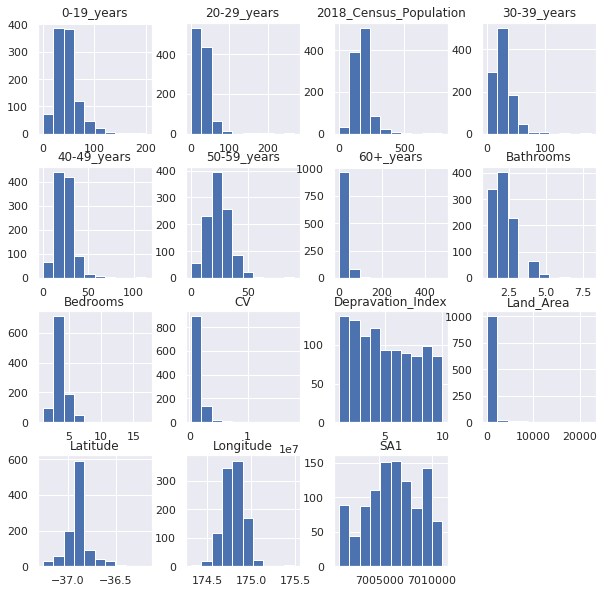

In [85]:
df_HouseData.hist(figsize=(10,10))

## Using Seaborn to have a closer Look at distributions

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


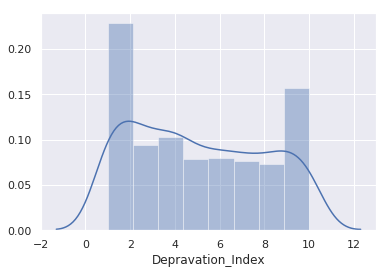

In [86]:
sns.distplot(df_HouseData['Depravation_Index'])

## Viewing correlations of each columns' data

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


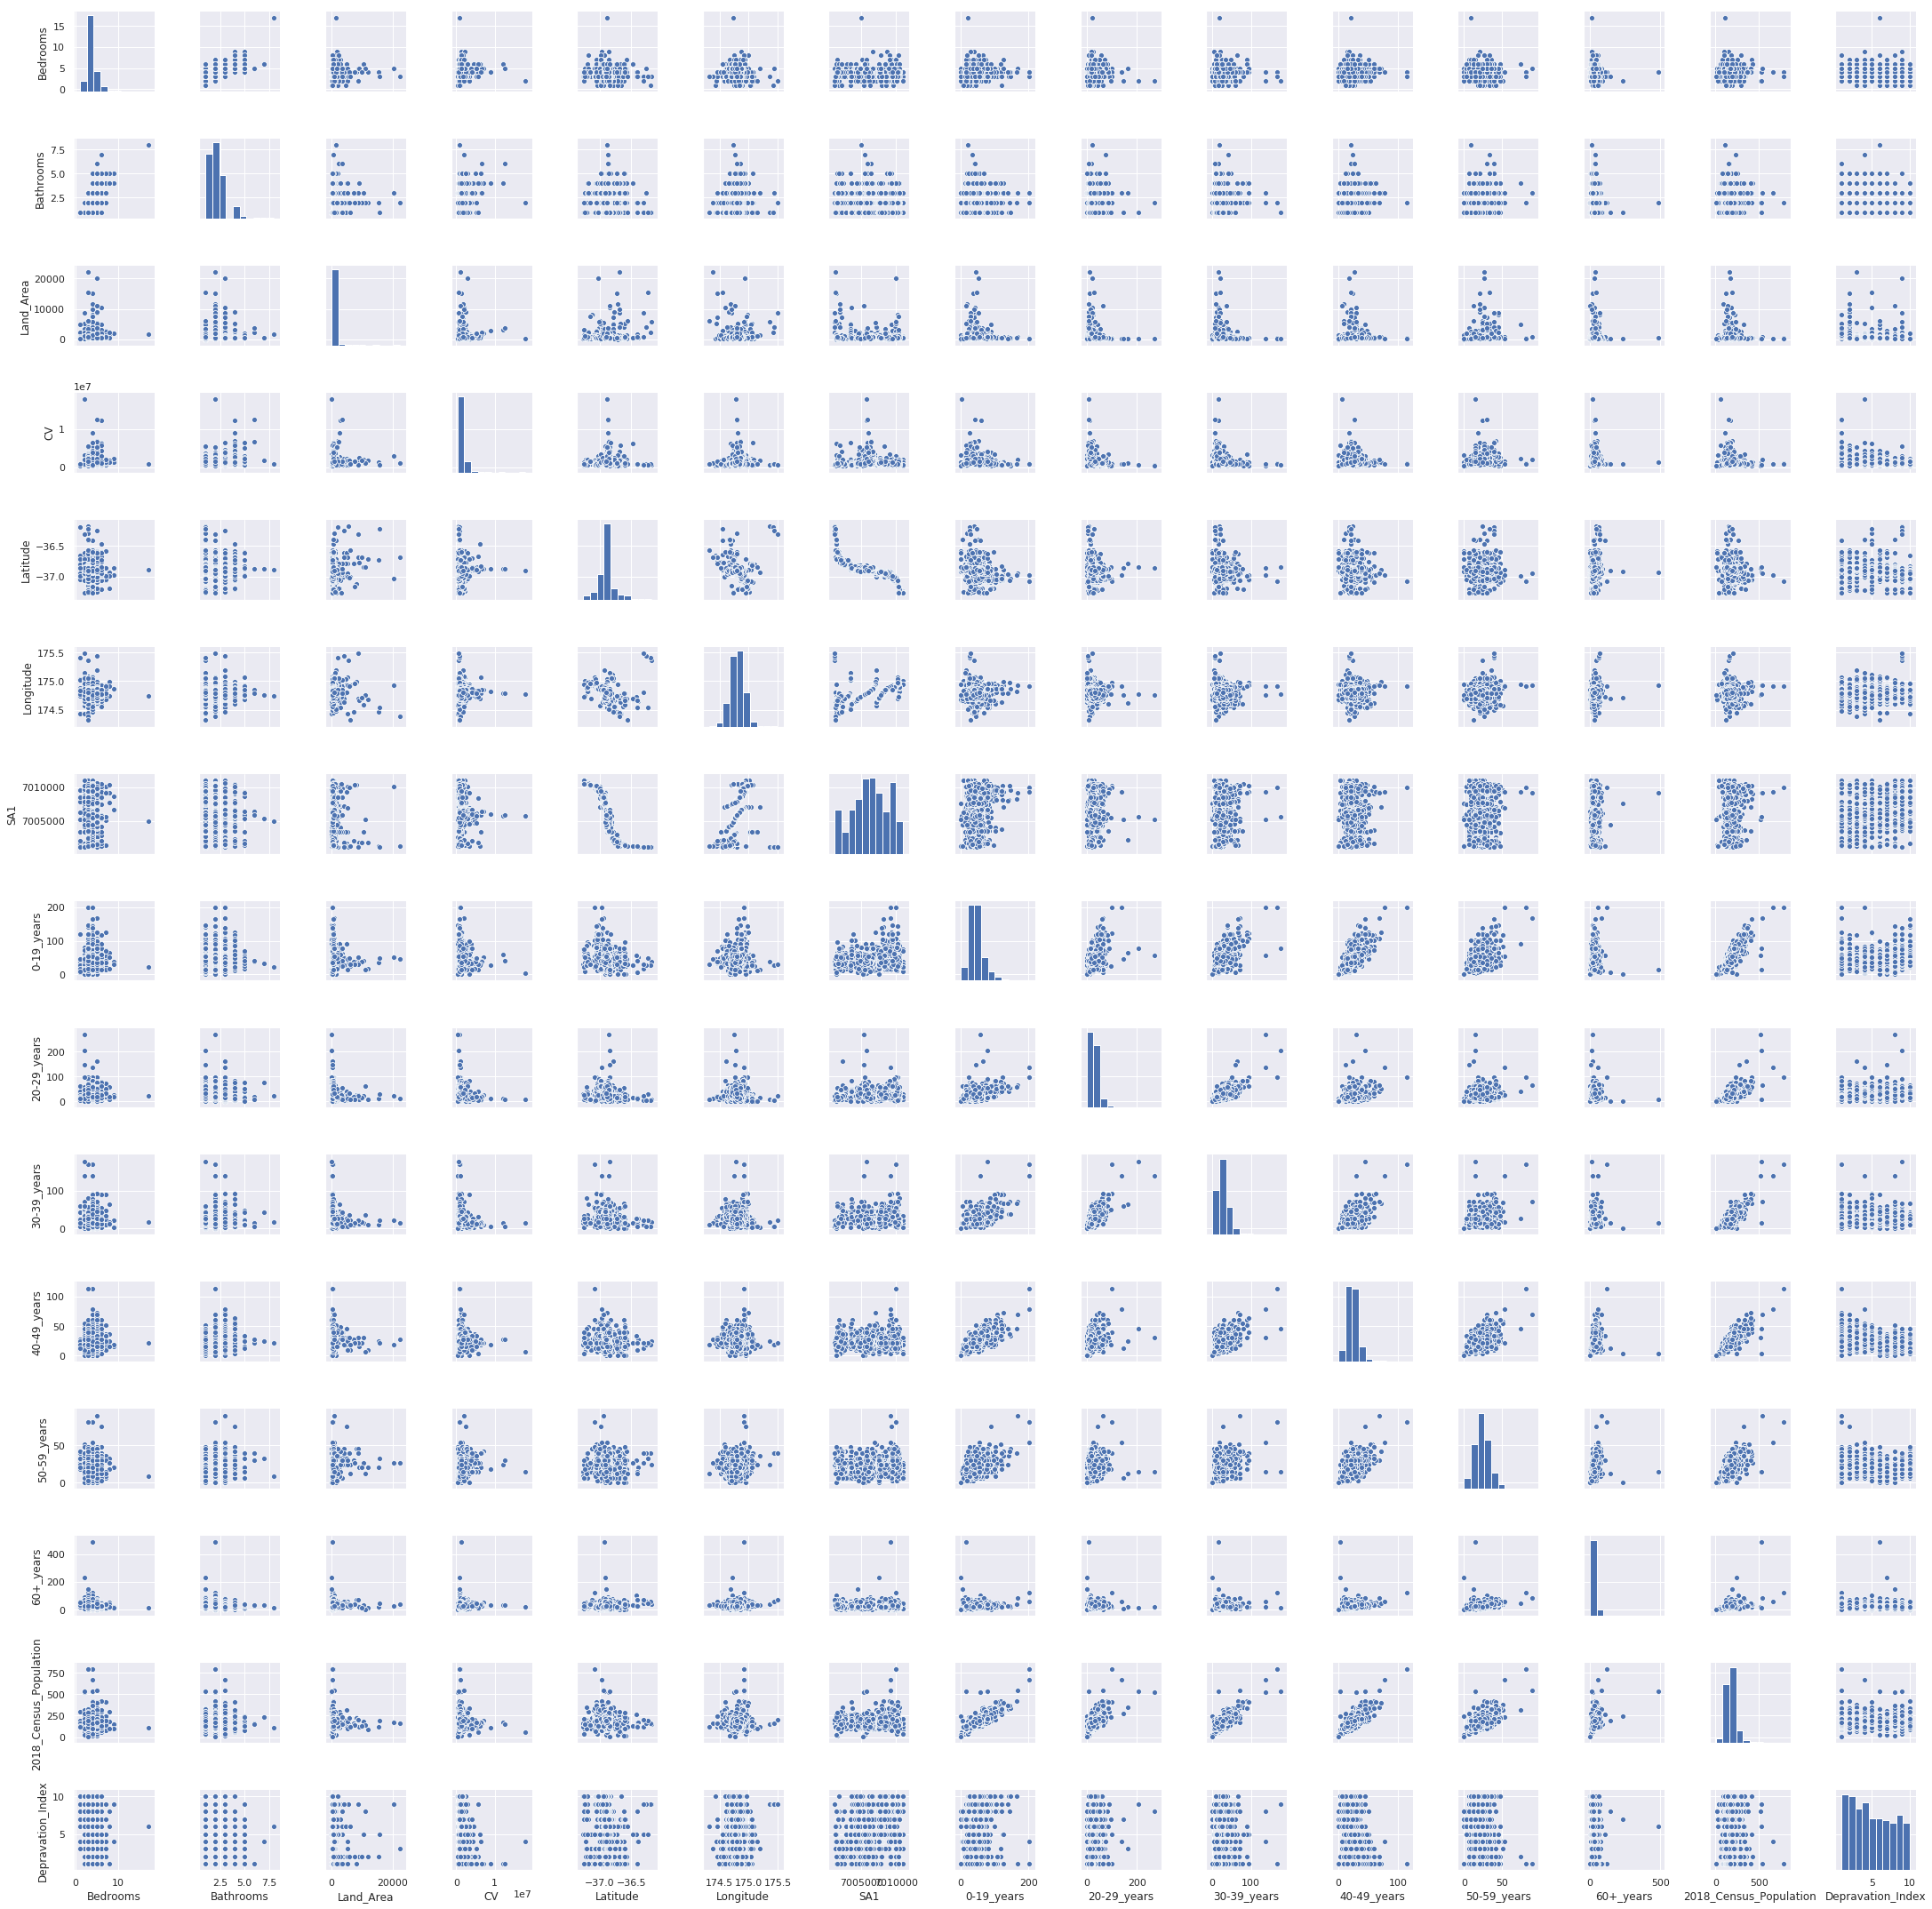

In [87]:
sns.pairplot(df_HouseData, size = 2.0)

## Using Heatmap to show correlations in data.
##### This may help quickly identify which correlations are worth identifying.

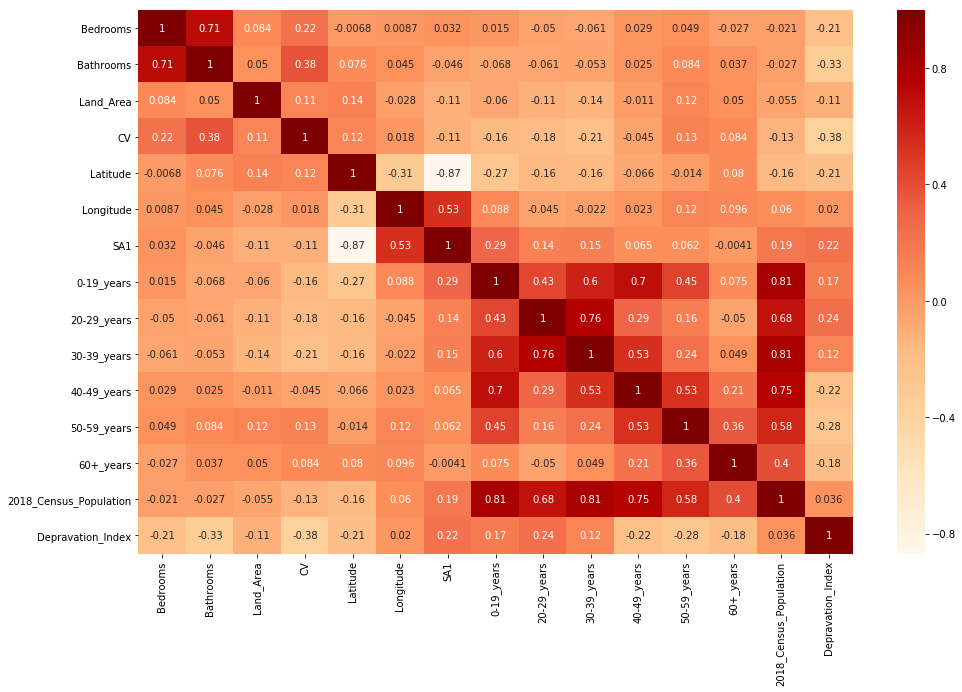

In [22]:
ax, fig = plt.subplots(figsize=(16,10))
correlation_matrix = df_HouseData.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="OrRd")
plt.show()

## Investigating cost

### Bathrooms vs Cost

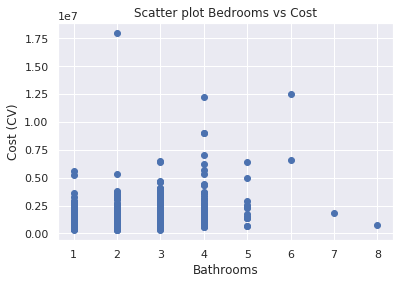

In [44]:
# Plotting with matplotlib
plt.scatter(df_HouseData['Bathrooms'], df_HouseData['CV'])
plt.title('Scatter plot Bedrooms vs Cost')
plt.xlabel('Bathrooms')
plt.ylabel('Cost (CV)')
plt.show()

### Bedrooms vs Cost

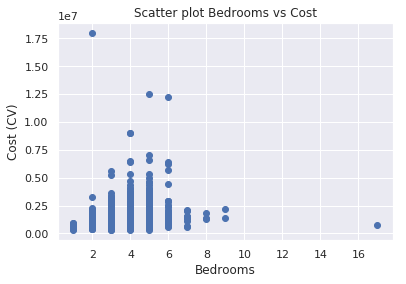

In [102]:
# Plotting with matplotlib
plt.scatter(df_HouseData['Bedrooms'], df_HouseData['CV'])
plt.title('Scatter plot Bedrooms vs Cost')
plt.xlabel('Bedrooms')
plt.ylabel('Cost (CV)')
plt.show()

### Land Area VS Cost

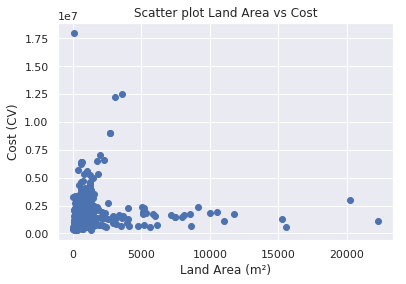

In [45]:
# Plotting with matplotlib
plt.scatter(df_HouseData['Land_Area'], df_HouseData['CV'] )
plt.title('Scatter plot Land Area vs Cost')
plt.xlabel('Land Area (m²)')
plt.ylabel('Cost (CV)')
plt.show()

### Suburb VS Cost

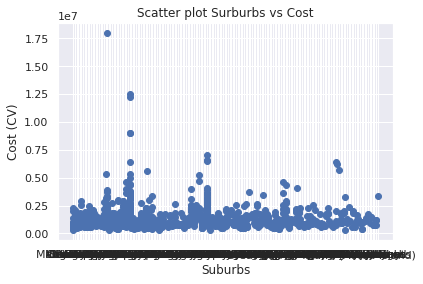

In [11]:
plt.scatter(df_HouseData['Suburbs'], df_HouseData['CV'] )
plt.title('Scatter plot Surburbs vs Cost')
plt.xlabel('Suburbs')
plt.ylabel('Cost (CV)')
plt.show()

### Depravation Index VS Cost

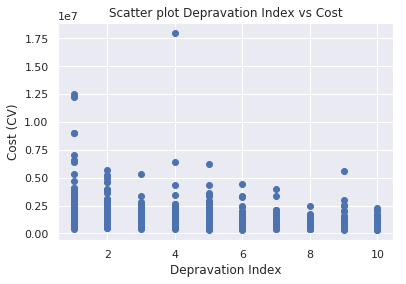

In [12]:
plt.scatter(df_HouseData['Depravation_Index'], df_HouseData['CV'] )
plt.title('Scatter plot Depravation Index vs Cost')
plt.xlabel('Depravation Index')
plt.ylabel('Cost (CV)')
plt.show()

### Census Population VS Cost

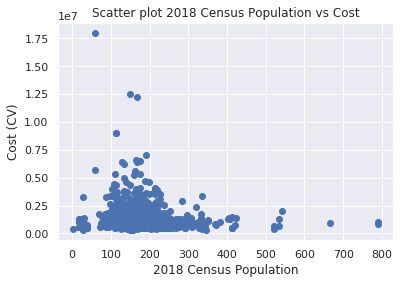

In [46]:
plt.scatter(df_HouseData['2018_Census_Population'], df_HouseData['CV'] )
plt.title('Scatter plot 2018 Census Population vs Cost')
plt.xlabel('2018 Census Population')
plt.ylabel('Cost (CV)')
plt.show()

## Creating Learning Model
#### Aim to use for cost prediction 

### performing 80-20 split for training and testing.

In [ ]:
## Droping all non relavant columns
df_HouseData = df_HouseData.drop(columns=['Suburbs','Address'])
df_HouseData.head()

In [26]:
train_x, test_x, train_y, test_y = train_test_split(df_HouseData.drop('CV', axis=1), df_HouseData['CV'], test_size=0.2, random_state=42)

## Using random_state to seed random number generatorr for splitting.

#### Checking split data

In [27]:
train_x.shape

(840, 14)

In [28]:
test_x.shape

(211, 14)

### Creating RandomForestClassifier object to train via fit method
(limits overfitting)

In [29]:
model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

## Grading the model's result
### attempt 1 score: 0.04265402843601896
#### Hoping to increase score by: 
- grouping cost (CV) by suburb (too many possible answers for the amount of data available)
- Binning cost and rounding to nearst mil

In [31]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.04265402843601896

In [50]:
confusion_matrix(test_y, predicted)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [48]:
probabilities = model.predict_proba(test_x)

In [ ]:
roc_auc_score(test_y, probabilities[:, 1])

In [34]:
df_HouseData.head()

,Bedrooms,Bathrooms,Land_Area,CV,Latitude,Longitude,SA1,0-19_years,20-29_years,30-39_years,40-49_years,50-59_years,60+_years,2018_Census_Population,Depravation_Index
0,5,3.0,714.0,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,174,6.0
1,5,3.0,564.0,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,129,1.0
2,6,4.0,626.0,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,129,1.0
3,2,1.0,65.0,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,120,2.0
4,3,1.0,601.0,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,231,9.0


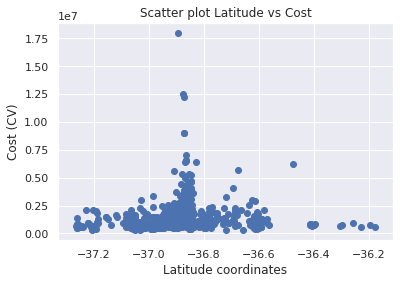

In [35]:
# Plotting with matplotlib
plt.scatter(df_HouseData['Latitude'], df_HouseData['CV'] )
plt.title('Scatter plot Latitude vs Cost')
plt.xlabel('Latitude coordinates')
plt.ylabel('Cost (CV)')
plt.show()

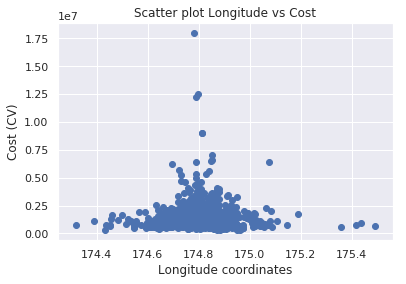

In [37]:
# Plotting with matplotlib
plt.scatter(df_HouseData['Longitude'], df_HouseData['CV'] )
plt.title('Scatter plot Longitude vs Cost')
plt.xlabel('Longitude coordinates')
plt.ylabel('Cost (CV)')
plt.show()

## Investigating ways to better tune data input for prediction model improvement

##### Testing with age groups removed

In [41]:
df_HouseData.describe()

,Bedrooms,Bathrooms,Land_Area,CV,Latitude,Longitude,SA1,2018_Census_Population,Depravation_Index
count,1051.000000,1051.000000,1051.000000,1.051000e+03,1051.000000,1051.000000,1.051000e+03,1051.000000,1051.000000
mean,3.777355,2.073264,856.989534,1.387521e+06,-36.893715,174.799325,7.006319e+06,179.914367,5.063749
std,1.169412,0.992044,1588.156219,1.182939e+06,0.130100,0.119538,2.591262e+03,71.059280,2.913471
min,1.000000,1.000000,40.000000,2.700000e+05,-37.265021,174.317078,7.001130e+06,3.000000,1.000000
25%,3.000000,1.000000,321.000000,7.800000e+05,-36.950565,174.720779,7.004416e+06,138.000000,2.000000
50%,4.000000,2.000000,571.000000,1.080000e+06,-36.893132,174.798575,7.006325e+06,174.000000,5.000000
75%,4.000000,3.000000,825.000000,1.600000e+06,-36.855789,174.880944,7.008384e+06,210.000000,8.000000
max,17.000000,8.000000,22240.000000,1.800000e+07,-36.177655,175.492424,7.011028e+06,789.000000,10.000000


In [40]:
df_HouseData = df_HouseData.drop(columns=['0-19_years','20-29_years','30-39_years','40-49_years','50-59_years','60+_years'])

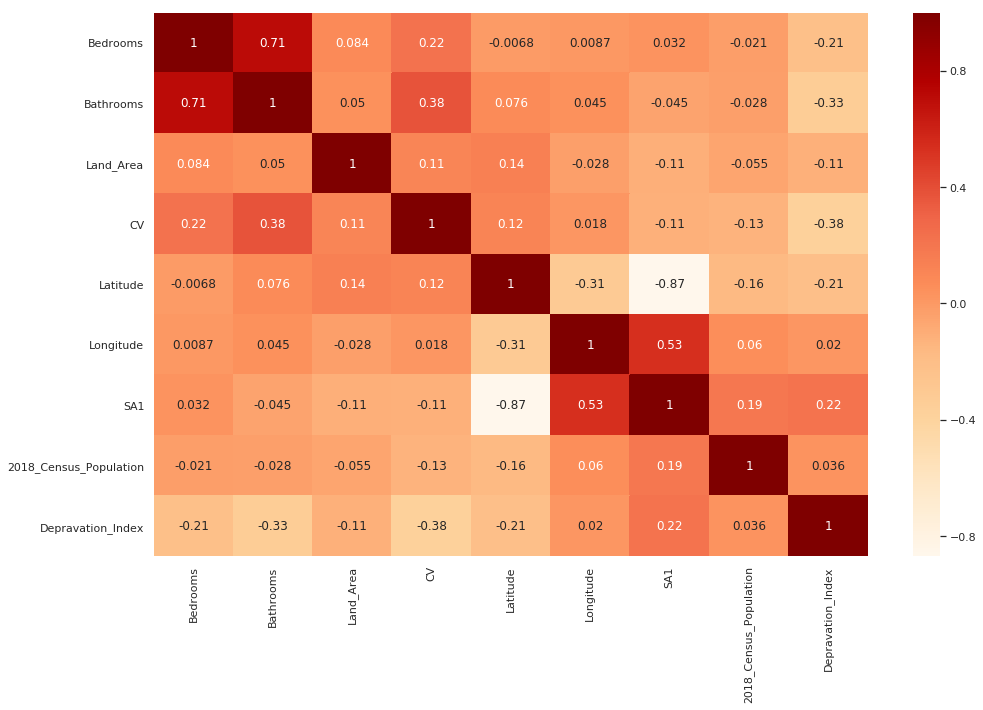

In [42]:
ax, fig = plt.subplots(figsize=(16,10))
correlation_matrix = df_HouseData.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="OrRd")
plt.show()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


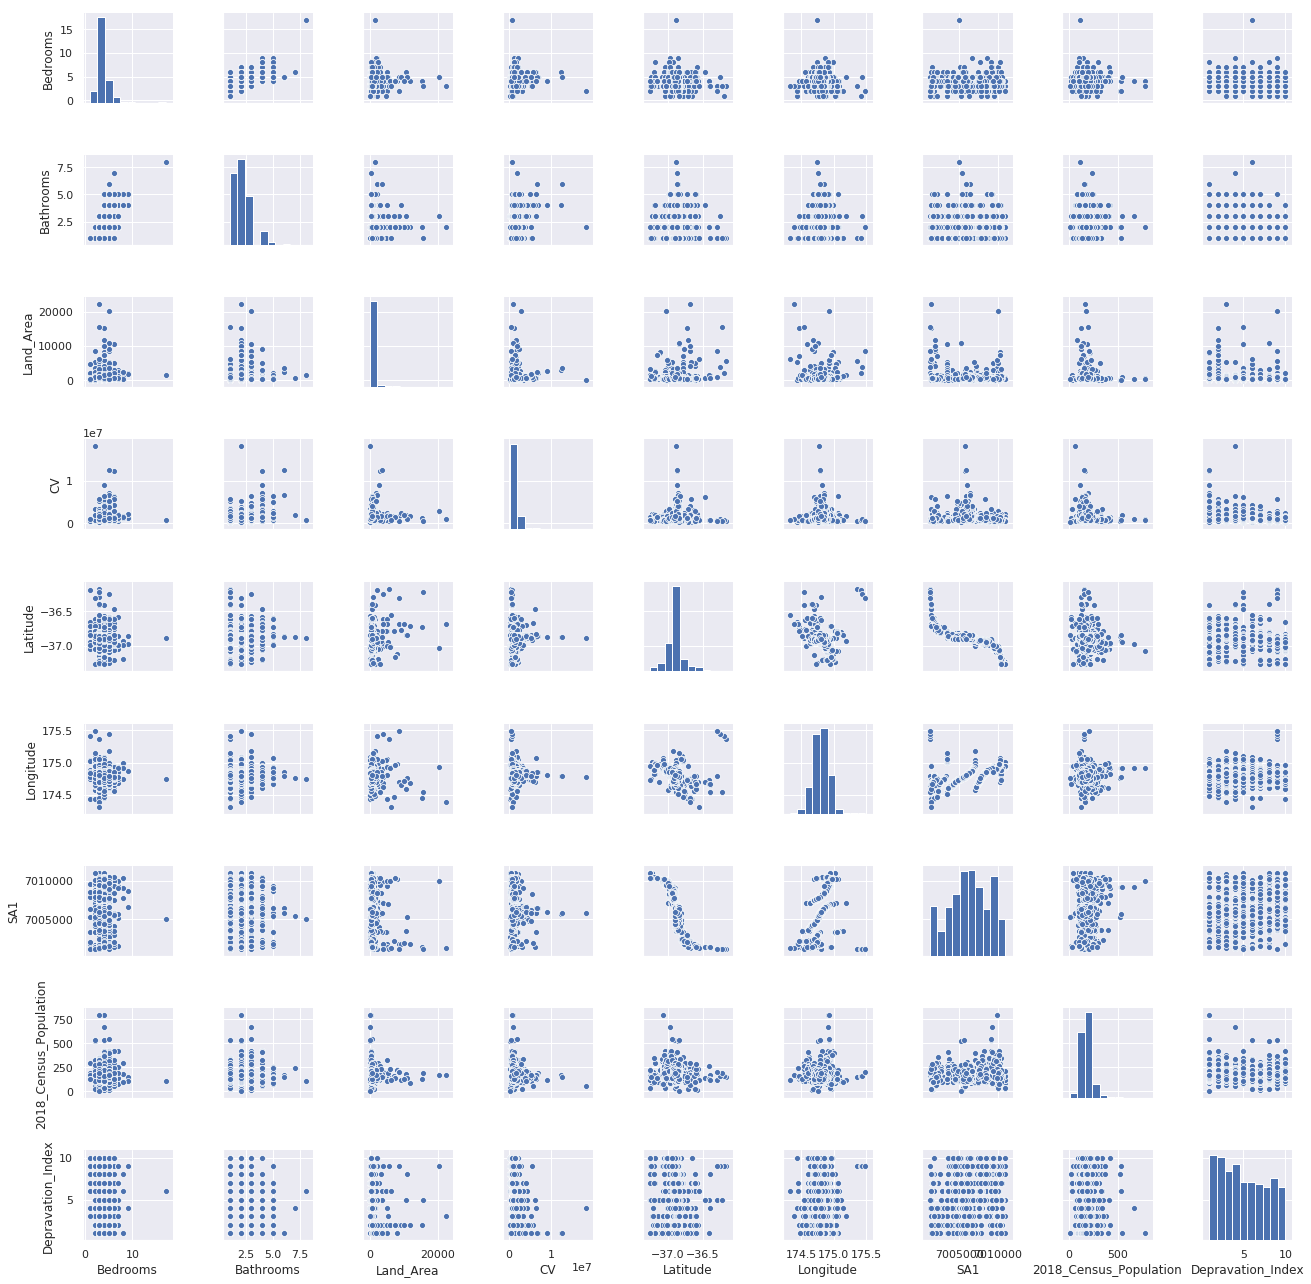

In [43]:
sns.pairplot(df_HouseData, size = 2.0)